In [158]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import seaborn as sns
from textwrap import fill
from synergy_dataset import Dataset, iter_datasets
from buscarpy import calculate_h0

/bin/bash: /home/max/.local/bin/pip: /usr/bin/python3.9: bad interpreter: No such file or directory


## Get the latest data from the HPC

In [144]:
%%sh
bash sync.sh

## Database of SVM runs

In [145]:
con = sqlite3.connect('output_data/experiments.sql')
df = pd.read_sql_query('SELECT * FROM runs',con)
df

,run_id,exp_started,version,thread
0,1,2024-02-20 17:03:59,0.0.0,0


In [146]:
version = '0.0.0'
stmt = f'SELECT orr.run_id,rec_id,screened_order,first_prediction,last_prediction,review_id,relevant,thread FROM ordered_records orr LEFT JOIN runs ON orr.run_id=runs.run_id WHERE version="{version}"'
#stmt = 'SELECT * FROM ordered_records WHERE run_id=1'
df = pd.read_sql_query(stmt,con)
print(df.groupby('review_id')['thread'].nunique())
df.head()


review_id
1    1
2    1
Name: thread, dtype: int64


,run_id,rec_id,screened_order,first_prediction,last_prediction,review_id,relevant,thread
0,1,https://openalex.org/W2402226166,2617,0.005503,0.001191,1,0,0
1,1,https://openalex.org/W2416808666,1114,0.005221,0.005735,1,0,0
2,1,https://openalex.org/W2060266518,2749,0.005816,0.000913,1,0,0
3,1,https://openalex.org/W2412464989,1982,0.005227,0.002714,1,0,0
4,1,https://openalex.org/W66518910,2036,0.005629,0.002600,1,0,0


In [148]:
stmt = f'SELECT * FROM reviews'
#stmt = 'SELECT * FROM ordered_records WHERE run_id=1'
reviews = pd.read_sql_query(stmt,con)
reviews.head()

,review_id,review_name,n_records,prevalence
0,1,Appenzeller-Herzog_2019,2873,0.009050
1,2,Bos_2018,4878,0.002050
2,3,Brouwer_2019,38114,0.001627


In [153]:
for i, row in reviews.sort_values('n_records').reset_index().iterrows():
    review_id = row['review_id']
    rdf = df[df['review_id']==review_id]
    for i, (name, group) in enumerate(rdf.groupby('thread')):
        group = group.sort_values('screened_order').reset_index(drop=True)
        stmt = f'SELECT n_screened, prediction FROM batch_predictions WHERE run_id="{rdf.run_id.values[0]}" AND review_id="{review_id}"'
        preds = pd.read_sql_query(stmt,con).sort_values('n_screened').reset_index(drop=True)
        for b, batch in preds.groupby('n_screened'):
            pass
        break
    break
    
group

287 287
316 29
348 32
383 35
422 39
465 43
512 47
564 52
621 57
684 63
753 69
829 76
912 83
1004 92
1105 101
1216 111
1338 122
1472 134
1620 148
1782 162
1961 179
2158 197
2374 216
2612 238


,run_id,rec_id,screened_order,first_prediction,last_prediction,review_id,relevant,thread
0,1,https://openalex.org/W2090358623,1,NaN,NaN,1,0,0
1,1,https://openalex.org/W2415261669,2,NaN,NaN,1,0,0
2,1,https://openalex.org/W2083533401,3,NaN,NaN,1,0,0
3,1,https://openalex.org/W2592070442,4,NaN,NaN,1,0,0
4,1,https://openalex.org/W1998849250,5,NaN,NaN,1,0,0
...,...,...,...,...,...,...,...,...
2868,1,https://openalex.org/W1966257188,2869,0.005207,0.000388,1,0,0
2869,1,https://openalex.org/W2772518344,2870,0.005623,0.000386,1,0,0
2870,1,https://openalex.org/W2941096119,2871,0.005245,0.000320,1,0,0
2871,1,https://openalex.org/W2413555834,2872,0.005328,0.000289,1,0,0


In [77]:
batch

,n_screened,prediction
323503,7433,0.000569
323504,7433,0.000656
323505,7433,0.002335
323506,7433,0.001617
323507,7433,0.000789
...,...,...
354179,7433,0.000827
354180,7433,0.000693
354181,7433,0.001240
354182,7433,0.000955


In [104]:
con = sqlite3.connect('output_data/experiments.sql')
version = '0.0.0'
stmt = f'SELECT * FROM batch_predictions'
#stmt = 'SELECT * FROM ordered_records WHERE run_id=1'
preds = pd.read_sql_query(stmt,con)
preds

,id,review,prediction,n_screened,run_id
0,1,Appenzeller-Herzog_2019,0.005617,287,1
1,2,Appenzeller-Herzog_2019,0.005446,287,1
2,3,Appenzeller-Herzog_2019,0.005803,287,1
3,4,Appenzeller-Herzog_2019,0.005450,287,1
4,5,Appenzeller-Herzog_2019,0.005693,287,1
...,...,...,...,...,...
78608,78609,Bos_2018,0.001149,1982,1
78609,78610,Bos_2018,0.001875,1982,1
78610,78611,Bos_2018,0.001700,1982,1
78611,78612,Bos_2018,0.001174,1982,1


In [16]:
train_idx = df[df['relevant']==1].index
train_idx.shape[0]

194200

In [24]:
','.join([str(1)]*5)

'1,1,1,1,1'

In [13]:
d_map = {}
max_len = 10
for d in iter_datasets():
    ti = d.metadata['publication']['title']
    d_map[d.name] = fill(ti, width=80)
d_map

{'Appenzeller-Herzog_2019': 'Comparative effectiveness of common therapies for Wilson disease: A systematic\nreview and meta‐analysis of controlled studies',
 'Bos_2018': 'Cerebral small vessel disease and the risk of dementia: A systematic review and\nmeta‐analysis of population‐based evidence',
 'Brouwer_2019': 'Psychological theories of depressive relapse and recurrence: A systematic review\nand meta-analysis of prospective studies',
 'Chou_2003': 'Comparative efficacy and safety of long-acting oral opioids for chronic non-\ncancer pain: a systematic review',
 'Chou_2004': 'Comparative efficacy and safety of skeletal muscle relaxants for spasticity and\nmusculoskeletal conditions: a systematic review',
 'Donners_2021': 'Pharmacokinetics and Associated Efficacy of Emicizumab in Humans: A Systematic\nReview',
 'Hall_2012': 'A Systematic Literature Review on Fault Prediction Performance in Software\nEngineering',
 'Jeyaraman_2020': 'Does the Source of Mesenchymal Stem Cell Have an Effe

In [14]:
def order_score(x):
    return 1-(x-x.min())/(x.max()-x.min())

In [16]:
llm_df

,openalex_id,y,py,pn
0,https://openalex.org/W2423293822,0,0.962591,1.257344e-03
1,https://openalex.org/W2554448004,0,0.898704,2.983925e-05
2,https://openalex.org/W2777949068,0,0.998105,5.569302e-07
3,https://openalex.org/W2984064738,0,0.977668,1.350333e-06
4,https://openalex.org/W2740901087,0,0.993529,5.942020e-04
...,...,...,...,...
253,https://openalex.org/W2973681494,0,0.953227,3.438037e-03
254,https://openalex.org/W2945243639,0,0.992940,6.647349e-06
255,https://openalex.org/W2765359511,0,0.992497,4.029715e-06
256,https://openalex.org/W3037252784,0,0.985165,6.279274e-07


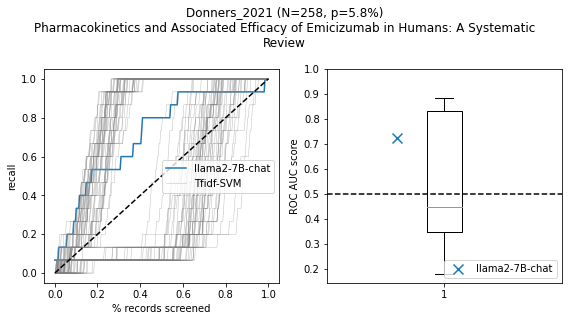

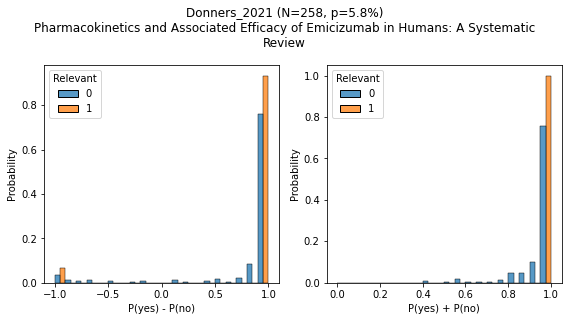

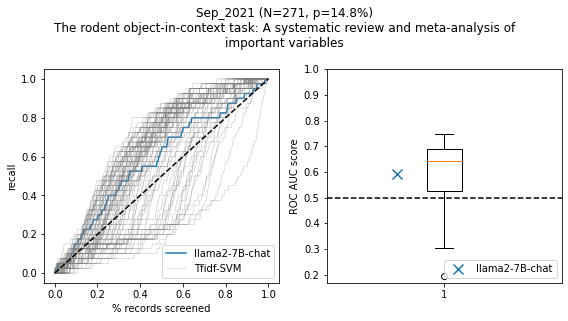

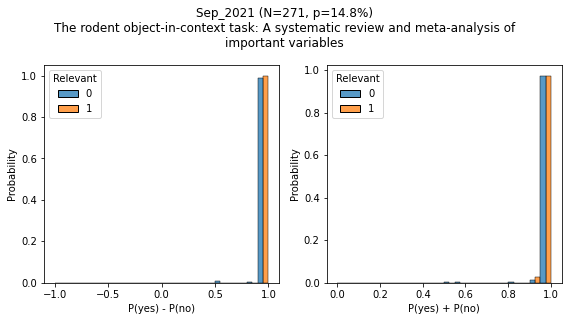

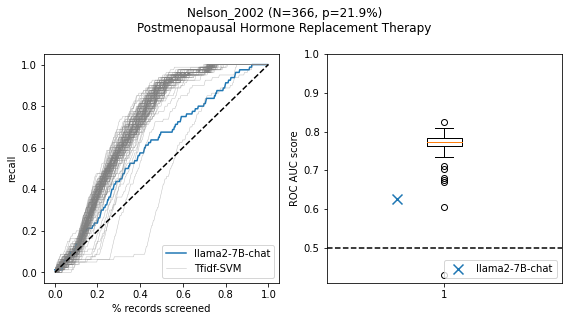

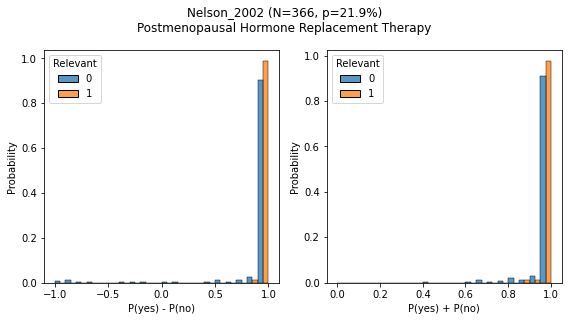

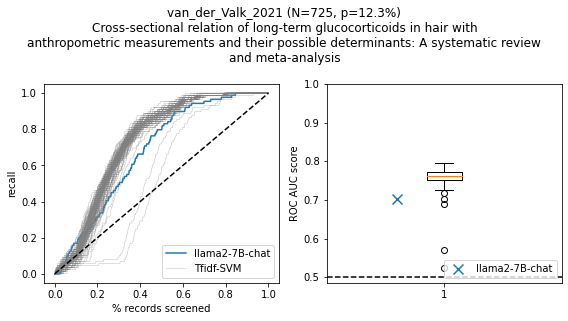

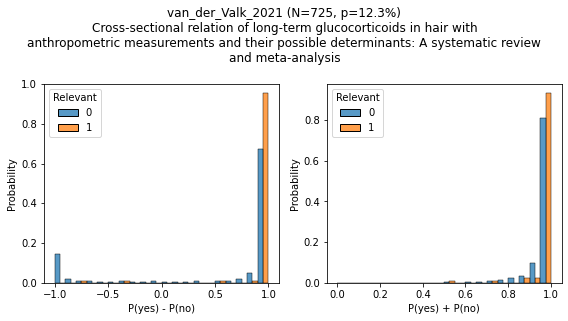

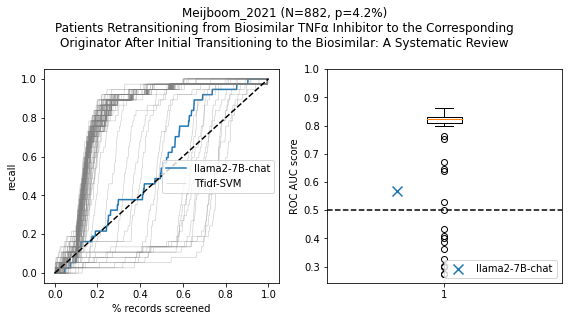

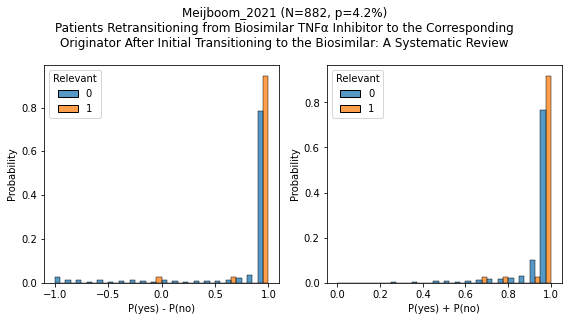

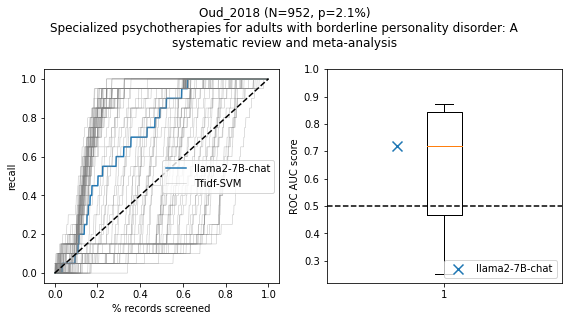

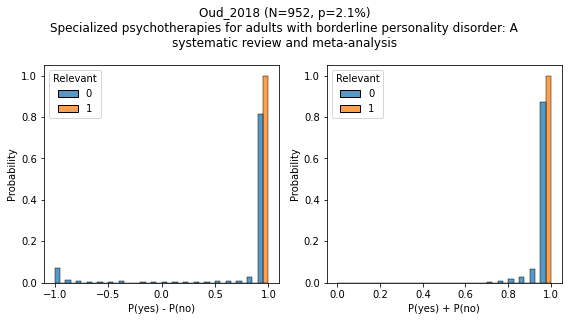

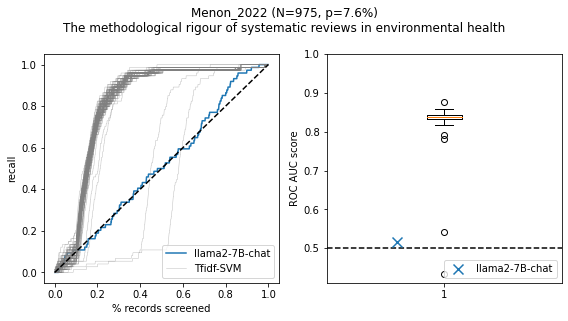

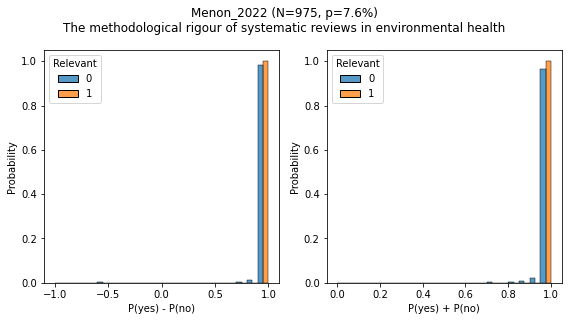

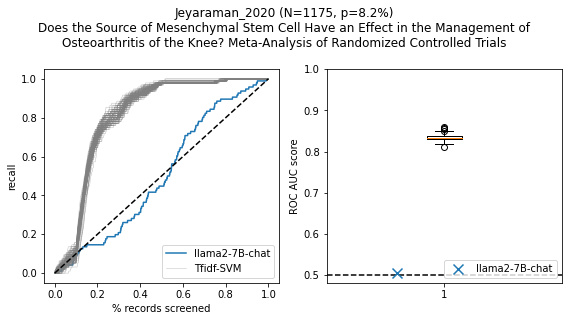

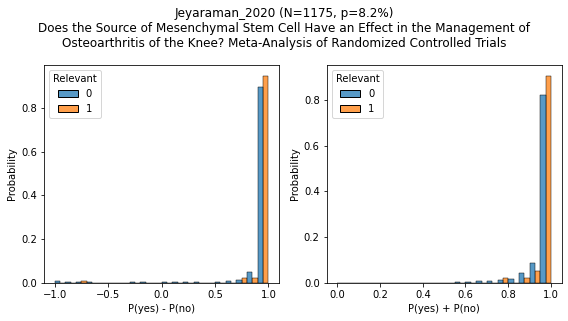

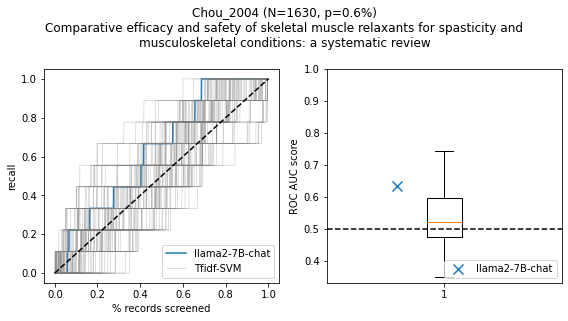

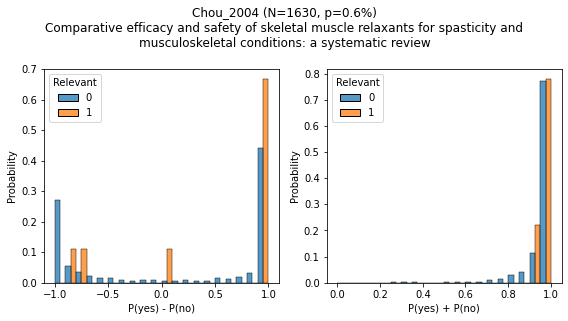

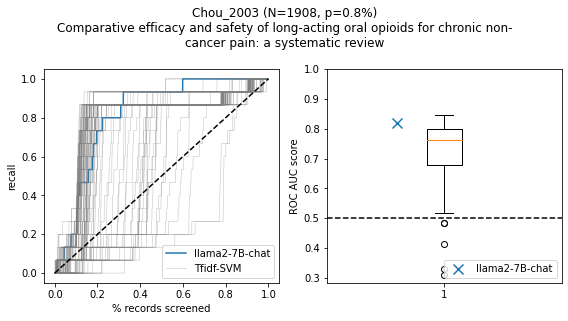

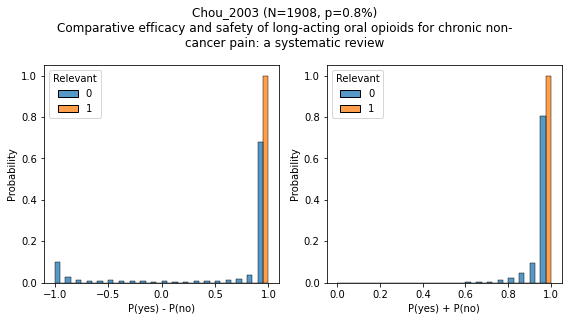

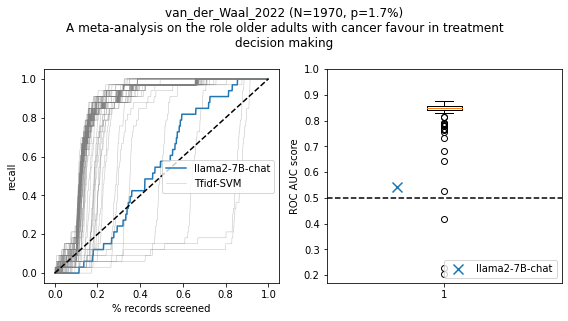

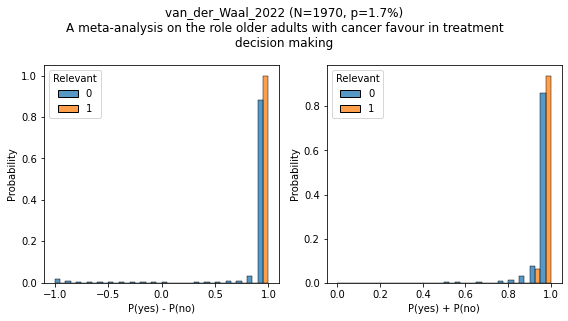

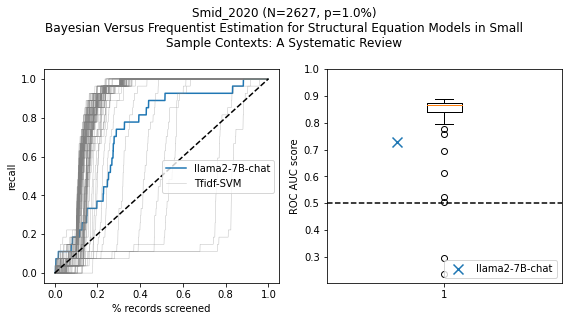

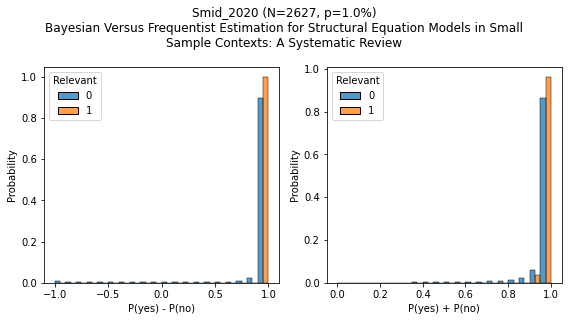

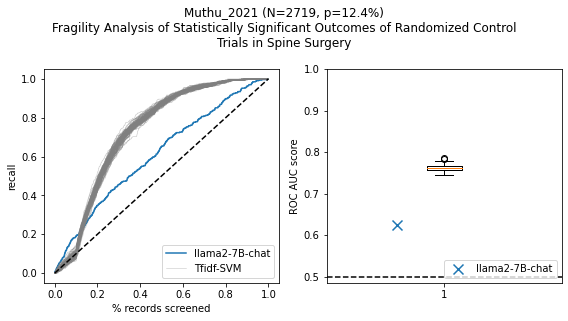

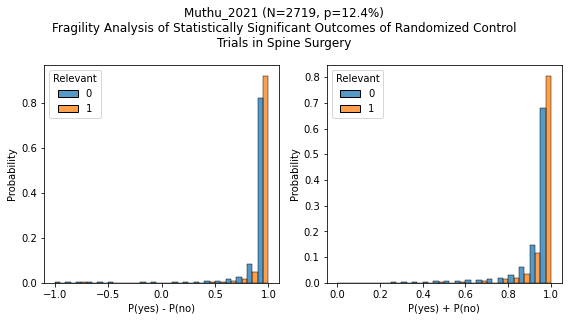

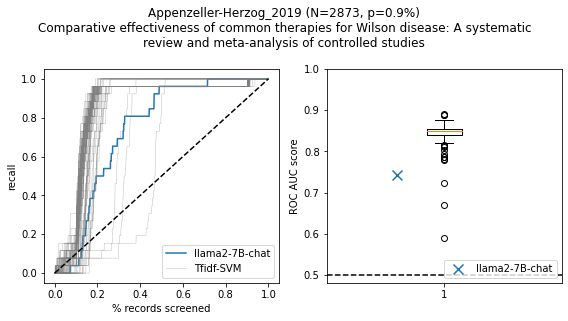

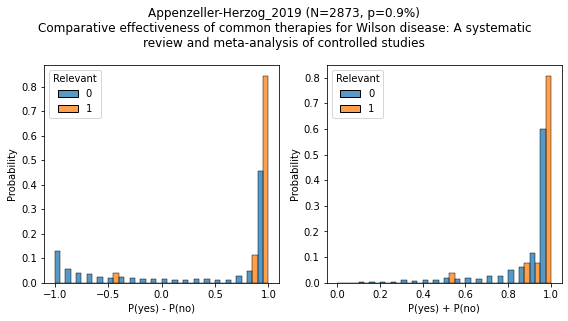

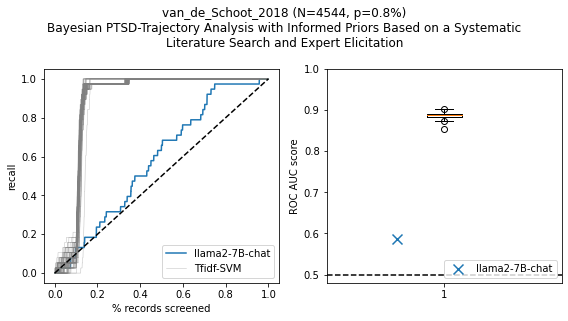

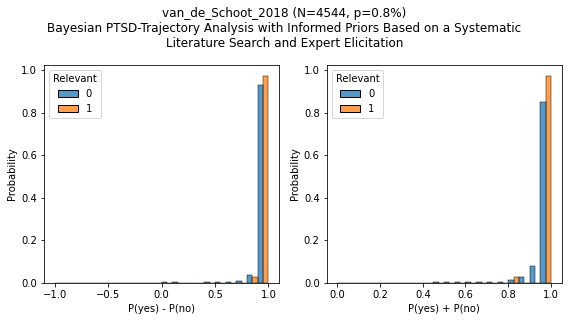

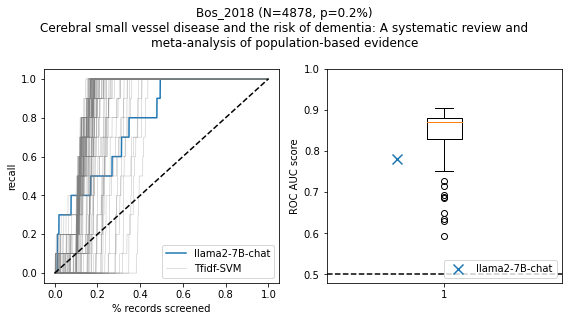

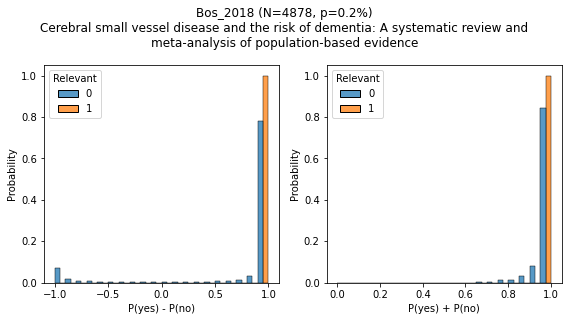

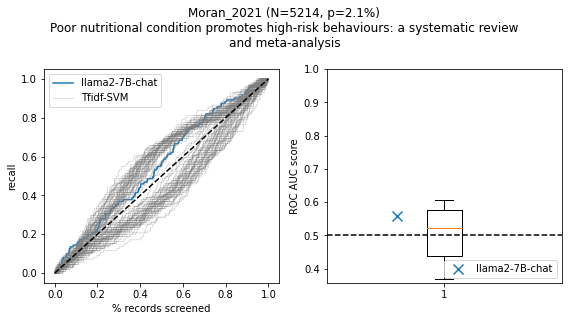

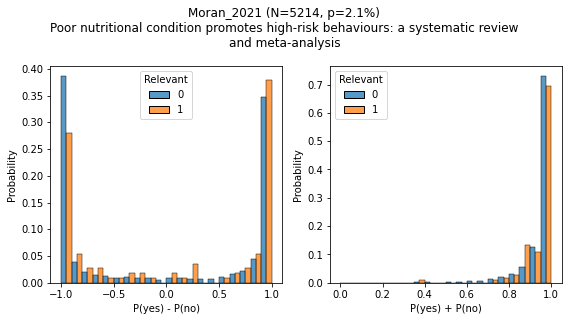

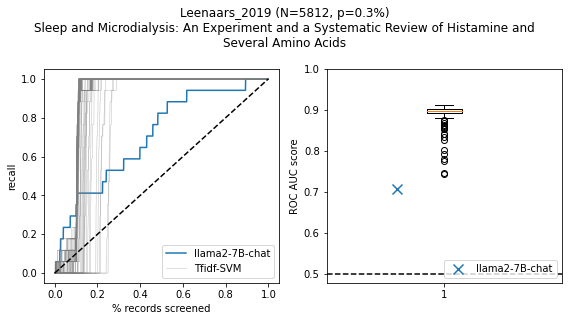

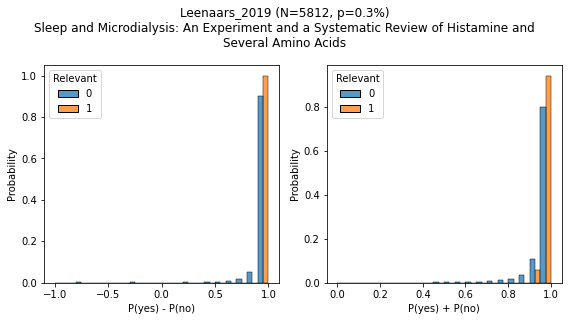

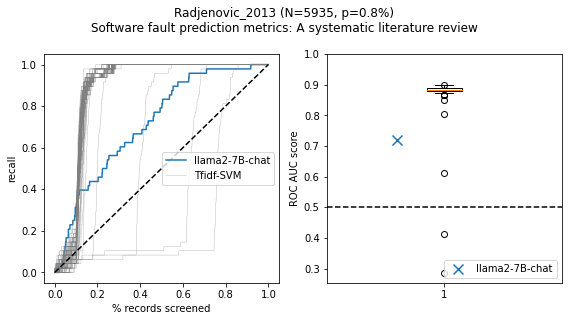

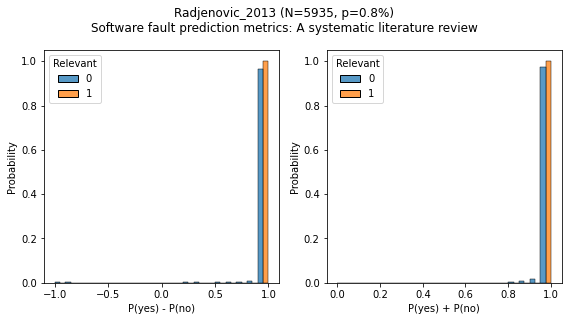

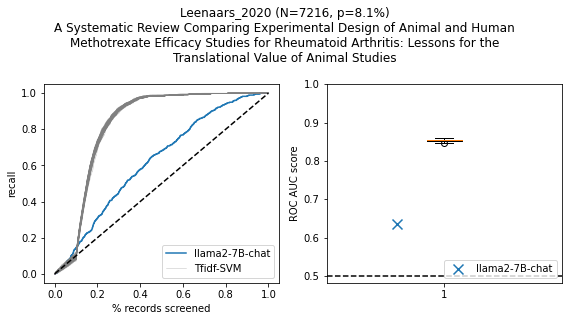

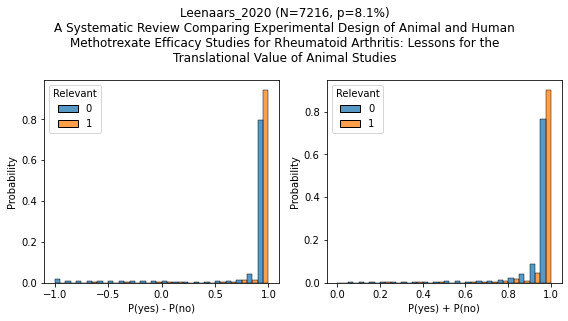

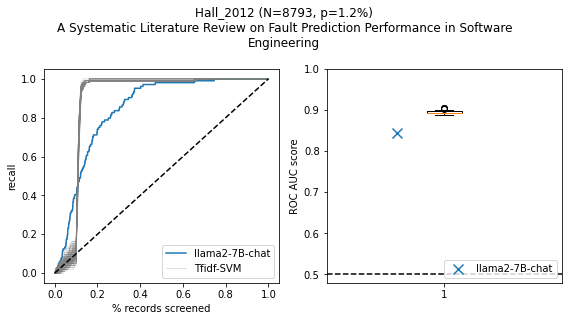

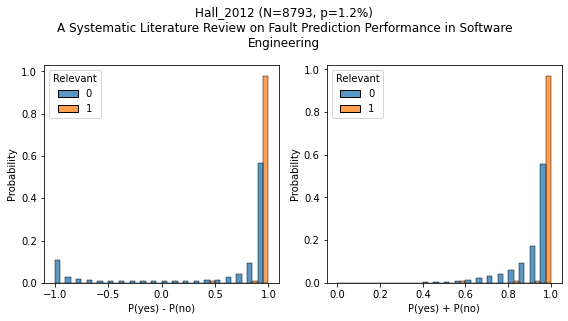

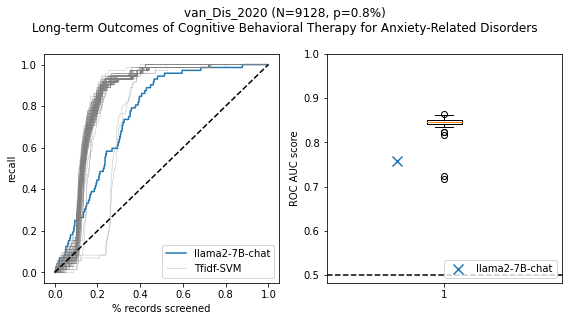

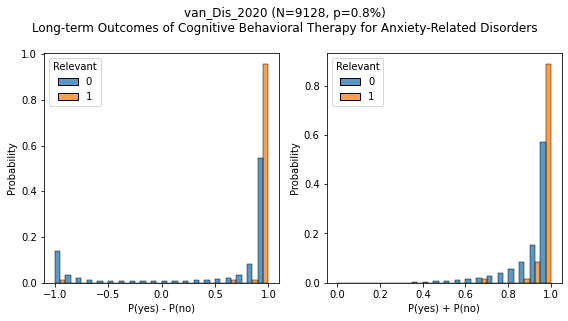

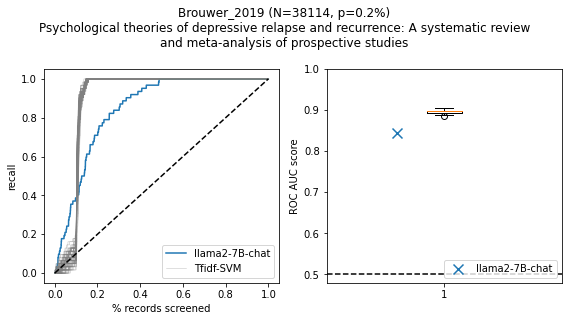

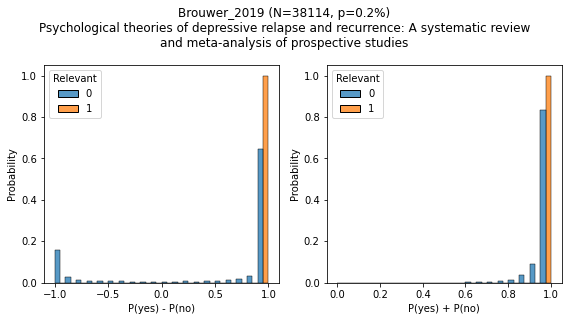

In [58]:
svm_auc_scores = []
llm_auc_scores = []
llm_alt_auc_scores = []
reviews = []

for i, row in df.groupby('review')['screened_order'].max().sort_values().reset_index().iterrows():
    review  = row['review']
    rdf = df[df['review']==review]
    try:
        llm_df = pd.read_csv(f'output_data/{review}_LLM.csv').dropna()
    except:
        continue
    if llm_df.shape[0] < 5:
        continue
    llm_df['pred'] = llm_df['py'] - llm_df['pn']    
    llm_df['pmass'] = llm_df['py'] + llm_df['pn']
    llm_df['alt_pred'] = llm_df['pred'] * llm_df['pmass']
    # Sort LLM results in descending order of pred, the order we would screen them
    llm_df = llm_df.sort_values('pred', ascending=False)
    # Calculate recall, the order, and x, the proportion of documents screened
    
    llm_df['recall'] = llm_df['y'].cumsum() / llm_df['y'].sum()
    llm_df['order'] = np.arange(llm_df.shape[0])
    llm_df['x'] = llm_df['order'] / llm_df.shape[0] 
    
    # Setup graph with two panels
    fig, axs = plt.subplots(1,2, figsize=(8,4.5))
    ax = axs[0]
    
    # Plot LLM recall curve
    ax.plot(llm_df['x'], llm_df['recall'], label='llama2-7B-chat')
    
    study_title = f'{review} (N={llm_df.shape[0]}, p={llm_df["y"].sum()/llm_df.shape[0]:.1%})'
    reviews.append(study_title)
    plt.suptitle(study_title + '\n' + d_map[review])
    
    #  Go through each active learning run, and plot progress
    aucs = []
    for i, (name, group) in enumerate(rdf.groupby('thread')):
        group = group.sort_values('screened_order').reset_index()
        group['score'] = order_score(group['screened_order'])
        group['x'] = group['screened_order'] / group.shape[0]
        group['recall'] = group['relevant'].cumsum()/group['relevant'].sum()
        aucs.append(roc_auc_score(group['relevant'],group['score']))
        ax.plot(group['x'], group['recall'], color='grey',alpha=0.5,lw=0.5, label='Tfidf-SVM' if i==0 else None)
    svm_auc_scores.append(aucs)
    
    # Plot a diagonal line showing random chance
    ax.plot([0,1],[0,1], color='black',ls='--')
    
    ax.legend()
    
    # Show the distribution of ROC AUC scores
    axs[1].boxplot(aucs)
    axs[1].axhline(0.5, color='black', ls='--')
    
    # Calculate LLM ROC AUC score and plot it with an x
    auc = roc_auc_score(llm_df['y'], llm_df['pred'])
    llm_auc_scores.append(auc)
    alt_auc = roc_auc_score(llm_df['y'], llm_df['alt_pred'])
    llm_alt_auc_scores.append(alt_auc)
    axs[1].scatter(
        0.8, auc,     
        marker='x',
        s=100,
        zorder=50,
        label='llama2-7B-chat'
    )
    
    # Legend and axis labels
    axs[1].legend(loc='lower right')
    axs[0].set_xlabel('% records screened')
    axs[0].set_ylabel('recall')
    axs[1].set_ylim(ymax=1)
    axs[1].set_ylabel('ROC AUC score')
    plt.tight_layout()
    plt.savefig(f'figures/{review}.pdf', bbox_inches='tight')
    plt.show()
    
    # New plot for distribution of p scores
    fig, axs = plt.subplots(1,2, figsize=(8,4.5))

    # Distribution of p(Yes)-P(no)
    g = sns.histplot(
        llm_df, hue='y', x='pred', stat='probability', 
        multiple='dodge', common_norm=False, ax=axs[0],
        binwidth=0.1, binrange=[-1,1], legend=True,
    )
    leg = g.axes.get_legend()
    leg.set_title('Relevant')
    axs[0].set_xlabel('P(yes) - P(no)')
    
    # Distribution of p(Yes)+P(no)
    g = sns.histplot(
        llm_df, hue='y', x='pmass', stat='probability', 
        multiple='dodge', common_norm=False, ax=axs[1],
        binwidth=0.05, binrange=[0,1], legend=True,
    )
    leg = g.axes.get_legend()
    leg.set_title('Relevant')
    axs[1].set_xlabel('P(yes) + P(no)')
    plt.suptitle(study_title + '\n' + d_map[review])
    
    fig.tight_layout()
    plt.savefig(f'figures/{review}_p_distribution.pdf', bbox_inches='tight')
    plt.show()


In [40]:
    llm_df['pred'] = llm_df['py'] - llm_df['pn']
    llm_df['alt_pred'] = llm_df['py'] + (1-llm_df['pn'])

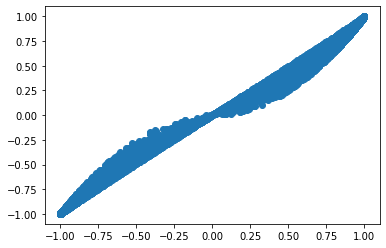

In [60]:
fig, ax = plt.subplots()

ax.scatter(llm_df['pred'], llm_df['alt_pred'])

Text(0, 0.5, 'P(yes)+(1-P(no))')

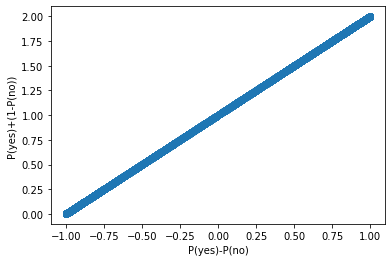

In [64]:
fig, ax = plt.subplots()

ax.scatter(llm_df['py']-llm_df['pn'], llm_df['py']+1-llm_df['pn'])

ax.set_xlabel('P(yes)-P(no)')
ax.set_ylabel('P(yes)+(1-P(no))')

Text(0, 0.5, '(P(yes)-(P(no))*(P(yes)+P(no))')

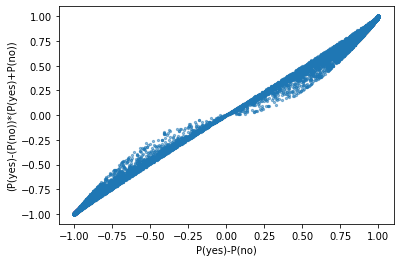

In [69]:
fig, ax = plt.subplots()

ax.scatter(
    llm_df['py']-llm_df['pn'], 
    (llm_df['py']-llm_df['pn'])*(llm_df['py']+llm_df['pn']),
    s=5, alpha=0.5
)

ax.set_xlabel('P(yes)-P(no)')
ax.set_ylabel('(P(yes)-(P(no))*(P(yes)+P(no))')

In [57]:
y = np.array([.4,.6])
n = np.array([.2,.4])
print(y-n)
print(y+1-n)
print((y-n)*(y+n))

[0.2 0.2]
[1.2 1.2]
[0.12 0.2 ]


In [55]:
(y-n)*(y+n)

array([0.12, 0.2 ])

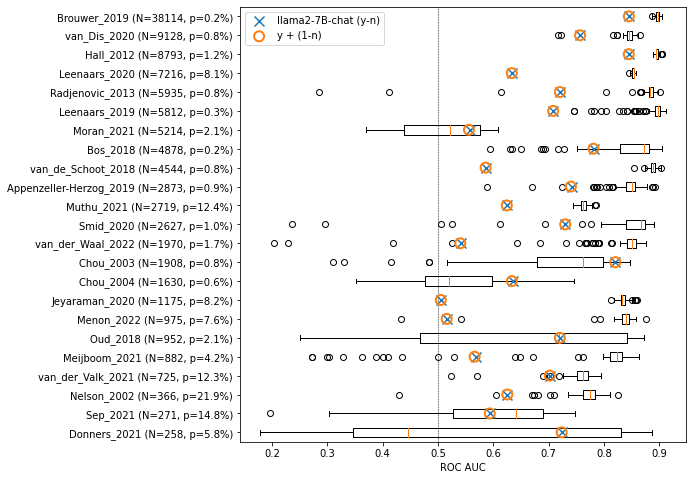

In [59]:
fig, ax = plt.subplots(figsize=(8,8))

ax.boxplot(svm_auc_scores, vert=False)
#llm_auc_scores
ax.set_yticklabels(reviews)
ax.scatter(
    llm_auc_scores, 
    np.arange(len(llm_auc_scores))+1,
    marker='x',
    s=100,
    zorder=50,
    label='llama2-7B-chat (y-n)'
)
ax.scatter(
    llm_alt_auc_scores, 
    np.arange(len(llm_alt_auc_scores))+1,
    marker='o',
    s=100,
    zorder=50,
    color='none',
    edgecolor='C1',
    lw=2,
    label='y + (1-n)'
)
#sns.stripplot(svm_auc_scores, orient='h')
ax.legend()
ax.axvline(0.5, lw=0.5, ls='--', color='black')
ax.set_xlabel('ROC AUC')
plt.savefig('figures/llm_svm_roc.pdf', bbox_inches='tight')
plt.show()

[Text(1, 0, 'SVM median'), Text(2, 0, 'LLM')]

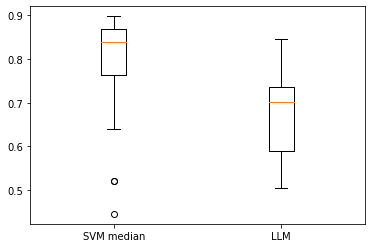

In [82]:
fig, ax = plt.subplots()
meds = [np.median(x) for x in svm_auc_scores]
ax.boxplot([meds, llm_auc_scores])
ax.set_xticklabels(['SVM median','LLM'])

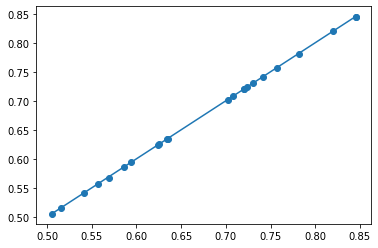

In [70]:
fig, ax = plt.subplots()

ax.scatter(llm_auc_scores, llm_alt_auc_scores)
mi, ma = min(llm_auc_scores), max(llm_auc_scores)

ax.plot([mi,ma], [mi,ma])

In [84]:
diff = (np.array(llm_alt_auc_scores) - np.array(llm_auc_scores)).mean()
sd = (np.array(llm_alt_auc_scores) - np.array(llm_auc_scores)).std()
f'{diff:.2%} ({sd:.2%})'

'-0.06% (0.07%)'